<a href="https://colab.research.google.com/github/Rochit02/ML-lab/blob/main/Lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import KBinsDiscretizer
from collections import Counter

np.random.seed(42)

In [4]:
FILEPATH = 'hdd_dataset.csv'
try:
    df = pd.read_csv(FILEPATH)
    features = ['capacity_bytes', 'is_legacy_format', 'smart_1_normalized', 'smart_1_raw']
    target = 'failure'

    imputer = SimpleImputer(strategy='median')
    X = imputer.fit_transform(df[features])
    y = df[target].values.astype(int)  # classification target

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)

    print("Data loaded successfully!")
    print(f"X shape: {X.shape}, y shape: {y.shape}")

except FileNotFoundError:
    print(f"Error: File '{FILEPATH}' not found")
    raise

Data loaded successfully!
X shape: (304957, 4), y shape: (304957,)


In [5]:
def equal_width_binning(values, bins=4):
    """Convert continuous values to categorical bins (equal width)."""
    binned = pd.cut(values, bins=bins, labels=False)
    return binned

def entropy(y):
    """Calculate entropy of labels y."""
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

print("\nA1: Entropy of target (failure)")
print("Entropy:", entropy(y))



A1: Entropy of target (failure)
Entropy: 0.0003359679821230605


In [6]:
def gini_index(y):
    """Calculate Gini index of labels y."""
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities**2)

print("\nA2: Gini Index of target (failure)")
print("Gini Index:", gini_index(y))



A2: Gini Index of target (failure)
Gini Index: 3.934903576929827e-05


In [7]:
def information_gain(y, x):
    """Calculate information gain for feature x."""
    base_entropy = entropy(y)
    values = np.unique(x)
    weighted_entropy = 0
    for v in values:
        subset_y = y[x == v]
        weighted_entropy += (len(subset_y) / len(y)) * entropy(subset_y)
    return base_entropy - weighted_entropy

def best_feature_to_split(X, y, binning='equal_width', bins=4):
    """Select feature with max info gain (root node)."""
    gains = {}
    for i in range(X.shape[1]):
        if np.issubdtype(X[:, i].dtype, np.number):
            if binning == 'equal_width':
                x_binned = equal_width_binning(X[:, i], bins=bins)
            else:
                est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='quantile')
                x_binned = est.fit_transform(X[:, [i]]).astype(int).ravel()
        else:
            x_binned = X[:, i]
        gains[i] = information_gain(y, x_binned)
    return max(gains, key=gains.get), gains

best_feature, gains = best_feature_to_split(X, y)
print("\nA3: Best feature for root node (by Info Gain):", features[best_feature])
print("Info Gains:", gains)



A3: Best feature for root node (by Info Gain): capacity_bytes
Info Gains: {0: np.float64(3.618260263769035e-05), 1: np.float64(0.0), 2: np.float64(1.4524077187195571e-08), 3: np.float64(9.307927020286988e-11)}


In [8]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=42)
clf.fit(X_train, y_train)

print("\nA5: Decision Tree trained!")



A5: Decision Tree trained!


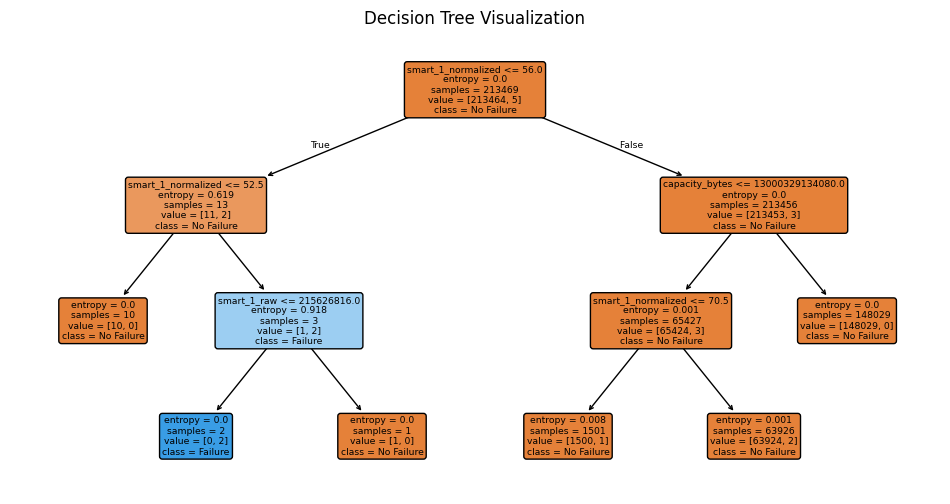

In [9]:
plt.figure(figsize=(12, 6))
plot_tree(clf, feature_names=features, class_names=["No Failure", "Failure"],
          filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


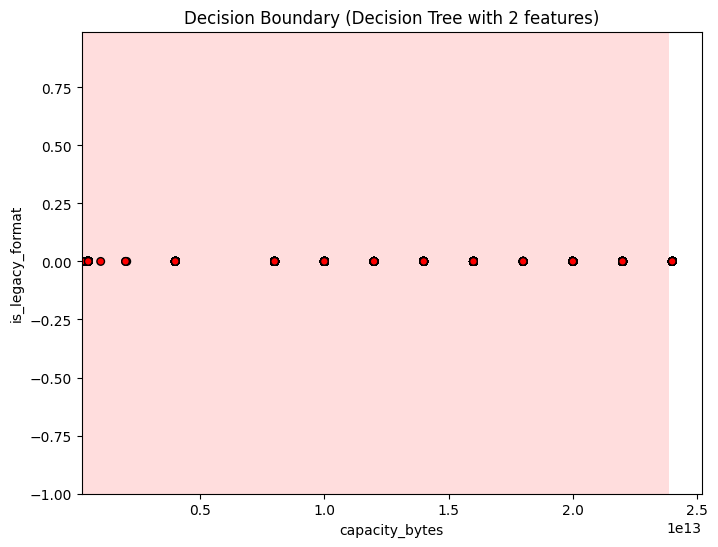

In [10]:
from matplotlib.colors import ListedColormap

X_two = X_train[:, :2]  # use first 2 features
y_two = y_train
clf_two = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=42)
clf_two.fit(X_two, y_two)

x_min, x_max = X_two[:, 0].min() - 1, X_two[:, 0].max() + 1
y_min, y_max = X_two[:, 1].min() - 1, X_two[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/200),
                     np.arange(y_min, y_max, (y_max-y_min)/200))

Z = clf_two.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.4)
plt.scatter(X_two[:, 0], X_two[:, 1], c=y_two, cmap=cmap_bold, edgecolor='k', s=30)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title("Decision Boundary (Decision Tree with 2 features)")
plt.show()
